In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

### Mixture of Gaussians Model

The model for the mixture of Gaussians is represented as:

$$ p(x; \theta) = \sum_{k=1}^{K} \omega_k N(x | \mu_k, \sigma_k^2) $$

where $ \omega_k $ are the mixture weights, and $ N(x | \mu_k, \sigma_k^2) $ is the Gaussian distribution with mean $ \mu_k $ and variance $ \sigma_k^2 $.

### Training: Log-Likelihood Function

The log-likelihood function is calculated for the given data $ D $. For a mixture of Gaussians, the likelihood function is:

$$ p(D; \mu_0, \mu_1, \sigma_0^2, \sigma_1^2, \omega) = \prod_{n=1}^{N} \left( (1 - \omega) N(x_n | \mu_0, \sigma_0^2) + \omega N(x_n | \mu_1, \sigma_1^2) \right) $$

Taking the logarithm of the likelihood function to simplify the product into a sum:

$$ \log p(D; \mu_0, \mu_1, \sigma_0^2, \sigma_1^2, \omega) = \sum_{n=1}^{N} \log \left( (1 - \omega) N(x_n | \mu_0, \sigma_0^2) + \omega N(x_n | \mu_1, \sigma_1^2) \right) $$

### Key Points:

1. The parameters of the model are $ \theta = (\mu_0, \mu_1, \sigma_0^2, \sigma_1^2, \omega) $.
2. The log-likelihood function represents how likely the observed data is given a set of parameters $ \theta $.
3. The log-likelihood function is used as the objective function for training. By optimizing this function with respect to $ \theta $, we find the most likely parameters that generated the observed data.

### Gaussian Log-Likelihood

To make the calculation easier, we take the logarithm of the Gaussian density function. The Gaussian density function is:

$$ N(x | \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left( -\frac{(x - \mu)^2}{2 \sigma^2} \right) $$

Taking the log of this:

$$ \log N(x | \mu, \sigma^2) = -\log(2 \pi) - \log(\sigma^2) - \frac{(x - \mu)^2}{2 \sigma^2} $$

This simplifies the Gaussian term for easier optimization.

### Log-Likelihood and Log-Sum-Exp Trick

Now, if only we could get the logarithm inside the sum, it would be easier! But we cannot. However, do we need to do that? We can use the property of exp and log: $ \exp(\log(x)) = x $. Let us apply this property to the log-likelihood function:

$$ \log p(D; \mu_0, \mu_1, \sigma_0^2, \sigma_1^2, \omega) = \log \left( \exp \left( \log(1 - \omega) + \log N(x_n | \mu_0, \sigma_0^2) \right) + \exp \left( \log(\omega) + \log N(x_n | \mu_1, \sigma_1^2) \right) \right) $$

Simplifying this:

$$ \log p(D; \mu_0, \mu_1, \sigma_0^2, \sigma_1^2, \omega) = \sum_{n=1}^{N} \log \left( \exp \left( \log(1 - \omega) + \log N(x_n | \mu_0, \sigma_0^2) \right) + \exp \left( \log(\omega) + \log N(x_n | \mu_1, \sigma_1^2) \right) \right) $$

We introduce the term $ a_i = \log(\omega_i) + \log N(x_n | \mu_i, \sigma_i^2) $, which simplifies to:

$$ \log p(D; \mu_0, \mu_1, \sigma_0^2, \sigma_1^2, \omega) = \sum_{n=1}^{N} \log \left( \sum_{i=0}^{1} \exp(a_i) \right) $$

This leads to:

$$ \log p(D; \mu_0, \mu_1, \sigma_0^2, \sigma_1^2, \omega) = \sum_{n=1}^{N} \log \left( \sum_{i=0}^{K-1} \exp(a_i) \right) $$

#### Important Notes:
1. We introduced $ a_i = \log(\omega_i) + \log N(x_n | \mu_i, \sigma_i^2) $ for convenience, and it will make more sense shortly.
2. While we've used two components in the example, this approach can be generalized for more components in the mixture.
3. The function $ \log \sum_{i=0}^{I-1} \exp(a_i) $ is known as the **log-sum-exp (LSE)** function. This function is commonly used in machine learning and statistics but can be numerically unstable due to underflow or overflow issues. To handle this, we use the following trick:

$$ \text{LSE}(a_0, a_1, \dots, a_{I-1}) = a^* + \text{LSE}(a_0 - a^*, a_1 - a^*, \dots, a_{I-1} - a^*) $$

where $ a^* = \max(a_0, a_1, \dots, a_{I-1}) $. This trick helps to avoid overflow or underflow problems.

#### General Log-Likelihood for MoG with K Components:

For a mixture of Gaussians with $ K $ components, the log-likelihood is:

$$ \log p(D; \theta) = \sum_{n=1}^{N} \log \left( \sum_{k=0}^{K-1} \exp \left( \log(\omega_k) + \log N(x_n | \mu_k, \Sigma_k) \right) \right) $$

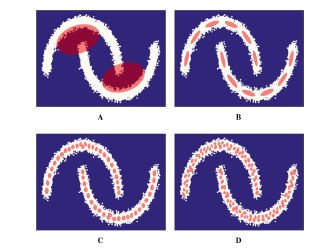

Fig.5 Several examples of MoGs with varying number of components: (a) .K = 2, (b) .K = 12, (c) .K = 50, (d) .K = 100.

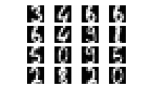
Fig.6 A few examples of handwritten, tiny images (.8 × 8 pixels).

### Training: Algorithms

Now we are ready to implement a training algorithm. Since we know the form of the log-likelihood function, we can choose any optimization algorithm. In practice, there are two main options:

1. **Expectation-Maximization (EM) Algorithm**:
    - This algorithm works in two stages:
      - **E-step**: Calculate expected probabilities for points belonging to specific components.
      - **M-step**: Update the parameters of components.
    - We will not discuss this algorithm here, as we are lazy deep-learning practitioners. However, I highly recommend looking up the details of the EM algorithm in one of the textbooks, e.g., [1, 4, 5], and implementing it.

2. **Gradient-Based Optimization**:
    - The second path is using gradient-based methods, which is simpler since we can use libraries with automatic differentiation (Autograd). 
    - The procedure is straightforward: calculate gradients of the log-likelihood with respect to the parameters and update the parameters. That’s it!
    - The only important detail is to remember to use the **Log-Sum-Exp (LSE)** function.

Some examples of fitting a mixture of Gaussians (for different numbers of components) to the half-moon data are shown in Fig. 2.5. As you can see:
- **Fitting too few components** (Fig. 2.5a) results in a poorly generalizable model.
- **Taking too many components** can lead to numerical instabilities, such as when a component is located on a datapoint and the variance collapses to zero.
- **More components** (e.g., see Fig. 2.5d) typically results in a better fit and a higher log-likelihood value.

Sometimes, regularization might be necessary to avoid overfitting or numerical instability, but we won’t discuss that in detail here. If you're interested, you can explore topics like the **Bayesian treatment of mixture of Gaussians** in textbooks.

###  Other Mixture Models

In this section, we focused on mixtures of Gaussians, but it's possible to formulate other mixture models depending on the type of observable data. For instance, for binary data, we would get a **Mixture of Bernoullis**:

$$ p(x; \theta) = \sum_{k=1}^{K} \pi_k \text{Bern}(x | \theta_k) $$

Similarly, you can build other mixture models. In general, constructing a mixture of distributions from the **exponential family** is straightforward because we can use the LSE trick to formulate a tractable log-likelihood-based training objective.

###  Coding Mixture of Gaussians (MoG)

Alright, my curious reader, it's time to move from theory to practice! Let’s code up a Mixture of Gaussians (MoG) model. We will train our MoG on simple data, such as **tiny handwritten images**. Some examples are shown in Fig. 2.6. These images are small, but training a model to generate such objects is nontrivial, as we will see.

Let's dive into the code and take a careful look at each line. For instance, we will use Gaussian components parameterized by means and variances, and we'll demonstrate the training procedure on these tiny images.


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Create synthetic data (2D for simplicity)
np.random.seed(42)
data_1 = np.random.normal(loc=[2, 2], scale=[1, 1], size=(500, 2))  # Cluster 1
data_2 = np.random.normal(loc=[7, 7], scale=[1, 1], size=(500, 2))  # Cluster 2
data = np.vstack([data_1, data_2])

# Convert data to torch tensor
X = torch.tensor(data, dtype=torch.float32)

# Number of components in the mixture
K = 2  # for simplicity, using 2 Gaussian components
N, D = X.shape  # N: number of data points, D: dimensionality of data

# Initialize parameters
mu = torch.randn(K, D, requires_grad=True)  # means (K, D)
sigma = torch.ones(K, D, requires_grad=True)  # std dev (K, D)
omega = torch.ones(K, requires_grad=True) / K  # mixture weights (K)

# Define the Gaussian PDF
def gaussian_pdf(x, mu, sigma):
    return (1 / (sigma * torch.sqrt(2 * torch.pi))) * torch.exp(-0.5 * ((x - mu) / sigma)**2)

# Log-Likelihood Function with Log-Sum-Exp trick
def log_likelihood(X, mu, sigma, omega):
    N = X.shape[0]
    log_likelihood_sum = 0
    
    for n in range(N):
        # Calculate the log of each component's contribution (LSE trick)
        log_p_k = torch.log(omega) + torch.sum(torch.log(gaussian_pdf(X[n], mu, sigma)), dim=1)
        
        # Use Log-Sum-Exp to prevent overflow/underflow
        log_likelihood_sum += torch.logsumexp(log_p_k, dim=0)
    
    return log_likelihood_sum

# Gradient-based optimization using gradient descent
optimizer = torch.optim.Adam([mu, sigma, omega], lr=0.1)

# Training loop
num_epochs = 500
log_likelihood_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Calculate log-likelihood and backpropagate
    loss = -log_likelihood(X, mu, sigma, omega)  # Negative log-likelihood
    loss.backward()
    
    optimizer.step()
    
    # Store log-likelihood values
    log_likelihood_values.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Plot the log-likelihood over epochs
plt.plot(log_likelihood_values)
plt.title('Log-Likelihood during Training')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.show()

# Final parameters
print(f"Final means (mu): {mu.detach().numpy()}")
print(f"Final std devs (sigma): {sigma.detach().numpy()}")
print(f"Final mixture weights (omega): {omega.detach().numpy()}")



Epoch [50/500], Log-Likelihood: -4043.1400
Epoch [100/500], Log-Likelihood: -3121.3333
Epoch [150/500], Log-Likelihood: -2504.7745
Epoch [200/500], Log-Likelihood: -1991.2784
Epoch [250/500], Log-Likelihood: -1520.2486
Epoch [300/500], Log-Likelihood: -1130.6290
Epoch [350/500], Log-Likelihood: -848.5213
Epoch [400/500], Log-Likelihood: -608.4413
Epoch [450/500], Log-Likelihood: -385.6495
Epoch [500/500], Log-Likelihood: -156.1685


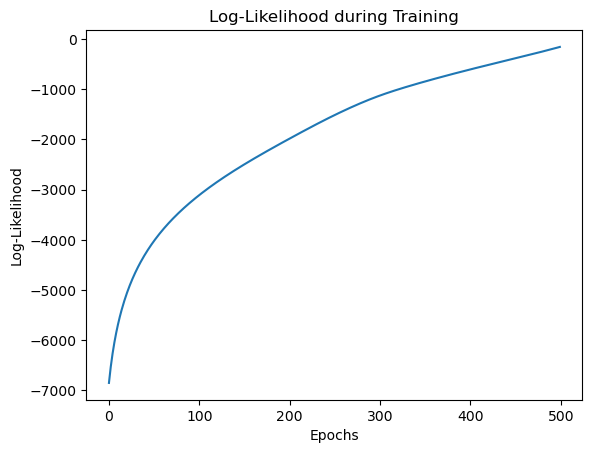

Final means (mu): [[5.69655384 6.01971813]
 [1.90223554 1.89275277]]
Final std devs (sigma): [[2.32436935 2.05316731]
 [0.87183676 0.89333048]]
Final mixture weights (omega): [37.31293301 13.68706699]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create synthetic data (2D for simplicity)
np.random.seed(42)
data_1 = np.random.normal(loc=[2, 2], scale=[1, 1], size=(500, 2))  # Cluster 1
data_2 = np.random.normal(loc=[7, 7], scale=[1, 1], size=(500, 2))  # Cluster 2
data = np.vstack([data_1, data_2])

# Convert data to numpy array
X = data

# Number of components in the mixture
K = 2  # Mixture components (2 Gaussians)
N, D = X.shape  # N: number of data points, D: dimensionality of data

# Initialize parameters
mu = np.random.randn(K, D)  # means (K, D)
sigma = np.ones((K, D))  # std dev (K, D)
omega = np.ones(K) / K  # mixture weights (K)

# Define the Gaussian PDF (univariate Gaussian for simplicity)
def gaussian_pdf(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Log-Likelihood Function with Log-Sum-Exp trick
def log_likelihood(X, mu, sigma, omega):
    N = X.shape[0]
    log_likelihood_sum = 0
    
    for n in range(N):
        # Calculate the log of each component's contribution (LSE trick)
        log_p_k = np.log(omega) + np.sum(np.log(gaussian_pdf(X[n], mu, sigma)), axis=1)
        
        # Use Log-Sum-Exp to prevent overflow/underflow
        log_likelihood_sum += np.log(np.sum(np.exp(log_p_k)))  # LSE
        
    return log_likelihood_sum

# Gradient of Log-Likelihood with respect to parameters (mu, sigma, omega)
def compute_gradients(X, mu, sigma, omega):
    N = X.shape[0]
    K = mu.shape[0]
    
    grad_mu = np.zeros_like(mu)
    grad_sigma = np.zeros_like(sigma)
    grad_omega = np.zeros_like(omega)
    
    for n in range(N):
        # Calculate the log of each component's contribution (LSE trick)
        log_p_k = np.log(omega) + np.sum(np.log(gaussian_pdf(X[n], mu, sigma)), axis=1)
        log_sum_exp = np.log(np.sum(np.exp(log_p_k)))  # Log-Sum-Exp (LSE)
        
        # Calculate responsibilities (gamma)
        gamma = np.exp(log_p_k - log_sum_exp)  # soft assignment
        
        # Update gradients
        for k in range(K):
            diff = X[n] - mu[k]
            grad_mu[k] += gamma[k] * diff / sigma[k]**2
            grad_sigma[k] += gamma[k] * (diff**2 / sigma[k]**3 - 1 / sigma[k])
            grad_omega[k] += gamma[k]
    
    # Normalize gradients for omega
    grad_omega /= N
    grad_mu /= N
    grad_sigma /= N
    
    return grad_mu, grad_sigma, grad_omega

# Gradient-based optimization using gradient descent
learning_rate = 0.1
num_epochs = 500
log_likelihood_values = []

# Training loop
for epoch in range(num_epochs):
    # Compute gradients
    grad_mu, grad_sigma, grad_omega = compute_gradients(X, mu, sigma, omega)
    
    # Update parameters using gradient descent
    mu += learning_rate * grad_mu
    sigma += learning_rate * grad_sigma
    omega += learning_rate * grad_omega
    
    # Calculate log-likelihood and store the value
    log_likelihood_value = log_likelihood(X, mu, sigma, omega)
    log_likelihood_values.append(log_likelihood_value)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Log-Likelihood: {log_likelihood_value:.4f}")

# Plot the log-likelihood over epochs
plt.plot(log_likelihood_values)
plt.title('Log-Likelihood during Training')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.show()

# Final parameters
print(f"Final means (mu): {mu}")
print(f"Final std devs (sigma): {sigma}")
print(f"Final mixture weights (omega): {omega}")


In [ ]:
import math
import random
import matplotlib.pyplot as plt

# Create synthetic data (2D for simplicity)
random.seed(42)
def generate_data():
    # Generate data from two Gaussian distributions
    data_1 = [(random.gauss(2, 1), random.gauss(2, 1)) for _ in range(500)]  # Cluster 1
    data_2 = [(random.gauss(7, 1), random.gauss(7, 1)) for _ in range(500)]  # Cluster 2
    return data_1 + data_2

# Gaussian PDF function (univariate for simplicity, but works in 2D as well)
def gaussian_pdf(x, mu, sigma):
    """Compute the probability of x given Gaussian parameters mu and sigma."""
    exponent = sum([(xi - mui)**2 / (2 * si**2) for xi, mui, si in zip(x, mu, sigma)])
    denominator = math.sqrt((2 * math.pi) ** len(x) * math.prod([si ** 2 for si in sigma]))
    return math.exp(-exponent) / denominator

# Log-Sum-Exp trick to compute the sum of exponentiated logs in a numerically stable way
def log_sum_exp(log_values):
    """Compute log(sum(exp(log_values))) safely."""
    max_log_value = max(log_values)
    return max_log_value + math.log(sum(math.exp(val - max_log_value) for val in log_values))

# Log-likelihood calculation for the Mixture of Gaussians model
def log_likelihood(data, mu, sigma, omega):
    """Compute the log-likelihood of the data given the MoG parameters."""
    total_log_likelihood = 0
    for x in data:
        # Compute the log-likelihood for each component and apply Log-Sum-Exp
        log_p_k = [math.log(omega[k]) + math.log(gaussian_pdf(x, mu[k], sigma[k])) for k in range(len(mu))]
        total_log_likelihood += log_sum_exp(log_p_k)
    return total_log_likelihood

# Gradient of the Log-Likelihood with respect to parameters
def compute_gradients(data, mu, sigma, omega):
    """Compute the gradients of the log-likelihood with respect to the parameters."""
    K = len(mu)
    N = len(data)
    
    grad_mu = [[0.0 for _ in range(len(mu[0]))] for _ in range(K)]  # (K, D)
    grad_sigma = [[0.0 for _ in range(len(mu[0]))] for _ in range(K)]  # (K, D)
    grad_omega = [0.0 for _ in range(K)]  # (K)
    
    for x in data:
        # Compute the responsibilities (gamma)
        log_p_k = [math.log(omega[k]) + math.log(gaussian_pdf(x, mu[k], sigma[k])) for k in range(K)]
        log_sum_exp_value = log_sum_exp(log_p_k)
        gamma = [math.exp(log_p_k[k] - log_sum_exp_value) for k in range(K)]
        
        # Compute gradients for each component k
        for k in range(K):
            diff = [xi - mui for xi, mui in zip(x, mu[k])]
            grad_mu[k] = [grad_mu_k + gamma[k] * d / (si ** 2) for grad_mu_k, d, si in zip(grad_mu[k], diff, sigma[k])]
            grad_sigma[k] = [grad_sigma_k + gamma[k] * (d ** 2 / (si ** 3) - 1 / si) for grad_sigma_k, d, si in zip(grad_sigma[k], diff, sigma[k])]
            grad_omega[k] += gamma[k]
    
    # Normalize gradients for omega
    grad_omega = [grad / N for grad in grad_omega]
    
    return grad_mu, grad_sigma, grad_omega

# Gradient descent optimization
def gradient_descent(data, mu, sigma, omega, learning_rate, num_epochs):
    log_likelihood_values = []
    
    for epoch in range(num_epochs):
        # Compute gradients
        grad_mu, grad_sigma, grad_omega = compute_gradients(data, mu, sigma, omega)
        
        # Update parameters using gradient descent
        for k in range(len(mu)):
            mu[k] = [mu_k + learning_rate * grad_mu_k for mu_k, grad_mu_k in zip(mu[k], grad_mu[k])]
            sigma[k] = [sigma_k + learning_rate * grad_sigma_k for sigma_k, grad_sigma_k in zip(sigma[k], grad_sigma[k])]
        omega = [omega_k + learning_rate * grad_omega_k for omega_k, grad_omega_k in zip(omega, grad_omega)]
        
        # Calculate log-likelihood and store the value
        log_likelihood_value = log_likelihood(data, mu, sigma, omega)
        log_likelihood_values.append(log_likelihood_value)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Log-Likelihood: {log_likelihood_value:.4f}")
    
    return mu, sigma, omega, log_likelihood_values

# Create synthetic data
data = generate_data()

# Initialize parameters
K = 2  # Mixture components (2 Gaussians)
D = 2  # Dimensionality (2D)
mu = [[random.random() * 10 for _ in range(D)] for _ in range(K)]  # means (K, D)
sigma = [[1.0 for _ in range(D)] for _ in range(K)]  # std dev (K, D)
omega = [1 / K for _ in range(K)]  # mixture weights (K)

# Set hyperparameters
learning_rate = 0.1
num_epochs = 500

# Train the model
mu, sigma, omega, log_likelihood_values = gradient_descent(data, mu, sigma, omega, learning_rate, num_epochs)

# Plot the log-likelihood over epochs
plt.plot(log_likelihood_values)
plt.title('Log-Likelihood during Training')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.show()

# Final parameters
print(f"Final means (mu): {mu}")
print(f"Final std devs (sigma): {sigma}")
print(f"Final mixture weights (omega): {omega}")


## Mixture of Gaussians (MoG) Implementation

In this section, we will implement a **Mixture of Gaussians (MoG)** model in PyTorch. This model will include the following features:

1. **Diagonal covariance matrices** (represented as log-variances for numerical stability).
2. **Trainable or fixed component probabilities** $(\omega_k$).
3. **Log-sum-exp** trick to efficiently compute the negative log-likelihood loss (NLL).

## Model Description

The **Mixture of Gaussians (MoG)** is a probabilistic model that represents a distribution as a weighted sum of multiple Gaussian distributions. The probability density function (PDF) of a mixture model with \(K\) components is given by:

$$
p(x; \theta) = \sum_{k=0}^{K-1} \omega_k \mathcal{N}(x | \mu_k, \Sigma_k)
$$

Where:
- $x$ is the data point.
- $\mu_k$ and $\Sigma_k$ are the mean and covariance of the $k$-th Gaussian component.
- $\omega_k$ is the weight (probability) associated with the $k$-th Gaussian, ensuring that $\sum_{k=0}^{K-1} \omega_k = 1$.

In the case of **diagonal covariance matrices**, we assume each Gaussian is represented by its mean $\mu_k$ and diagonal covariance matrix $\Sigma_k = \text{diag}(\sigma_k^2)$. This simplifies to a diagonal normal distribution.

The log-likelihood for a mixture model is:

$$
\log p(D; \theta) = \sum_{n=1}^{N} \log \left( \sum_{k=0}^{K-1} \omega_k \mathcal{N}(x_n | \mu_k, \Sigma_k) \right)
$$

## Implementation Details

### Step 1: Define the Model Class

```python
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MoG(nn.Module):
    def __init__(self, D, K, uniform=False):
        super(MoG, self).__init__()
        
        print('MoG by JT.')
        
        # Hyperparameters
        self.uniform = uniform
        self.D = D  # Dimensionality of the input
        self.K = K  # Number of components
        
        # Parameters for the mixture of Gaussians model
        # Means (mu) for each Gaussian component: (1, K, D)
        self.mu = nn.Parameter(torch.randn(1, self.K, self.D) * 0.25 + 0.5)
        
        # Log-variances (log of the diagonal covariance matrix): (1, K, D)
        self.log_var = nn.Parameter(-3. * torch.ones(1, self.K, self.D))
        
        # Parameters for the mixture probabilities
        if self.uniform:
            # If uniform, we do not update weights and set them to zeros (fixed probabilities)
            self.w = torch.zeros(1, self.K)
            self.w.requires_grad = False
        else:
            # Otherwise, we use trainable parameters (w) to compute the probabilities
            self.w = nn.Parameter(torch.zeros(1, self.K))
        
        # Constant PI
        self.PI = torch.tensor(np.pi)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MoG(nn.Module):
    def __init__(self, D, K, uniform=False):
        super(MoG, self).__init__()
        
        print('MoG by JT.')
        
        # Hyperparameters
        self.uniform = uniform
        self.D = D  # Dimensionality of the input
        self.K = K  # Number of components
        
        # Parameters for the mixture of Gaussians model
        # Means (mu) for each Gaussian component: (1, K, D)
        self.mu = nn.Parameter(torch.randn(1, self.K, self.D) * 0.25 + 0.5)
        
        # Log-variances (log of the diagonal covariance matrix): (1, K, D)
        self.log_var = nn.Parameter(-3. * torch.ones(1, self.K, self.D))
        
        # Parameters for the mixture probabilities
        if self.uniform:
            # If uniform, we do not update weights and set them to zeros (fixed probabilities)
            self.w = torch.zeros(1, self.K)
            self.w.requires_grad = False
        else:
            # Otherwise, we use trainable parameters (w) to compute the probabilities
            self.w = nn.Parameter(torch.zeros(1, self.K))
        
        # Constant PI
        self.PI = torch.tensor(np.pi)

    def log_diag_normal(self, x, mu, log_var, reduction='sum', dim=1):
        """
        Computes the log of the diagonal Gaussian pdf for each component.
        
        Parameters:
        - x: Input data (B, D)
        - mu: Means for the components (1, K, D)
        - log_var: Log-variances for the components (1, K, D)
        
        Returns:
        - log_p: Log-probability of the data under the Gaussian components (B, K)
        """
        log_p = -0.5 * torch.log(2. * self.PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x.unsqueeze(1) - mu)**2
        return log_p

In [1]:
    def forward(self, x, reduction='mean'):
        """
        Forward pass for the Mixture of Gaussians model.
        
        Parameters:
        - x: Input data (B, D)
        
        Returns:
        - NLL_loss: The negative log-likelihood loss
        """
        # Calculate the log of the mixture probabilities (softmax ensures they sum to 1)
        log_pi = torch.log(F.softmax(self.w, dim=1))  # Log-probabilities for each Gaussian component (B, K)
        
        # Calculate the log-probabilities for the Gaussian components (B, K)
        log_N = torch.sum(self.log_diag_normal(x, self.mu, self.log_var), 2)  # (B, K)
        
        # Negative Log-Likelihood (NLL) loss computation using the log-sum-exp trick
        NLL_loss = -torch.logsumexp(log_pi + log_N, dim=1)  # (B,)
        
        # Return the loss in the specified reduction form (mean or sum)
        if reduction == 'mean':
            return torch.mean(NLL_loss)
        elif reduction == 'sum':
            return torch.sum(NLL_loss)
        else:
            return NLL_loss


In [ ]:
# Define the number of components (K) and dimensionality (D)
K = 3  # Number of Gaussian components
D = 2  # Dimensionality of input data

# Initialize the Mixture of Gaussians model
model = MoG(D, K)

# Create synthetic data: let's assume 2D points
data = torch.randn(100, D)  # 100 samples, 2D data

# Forward pass to compute the NLL loss
nll_loss = model(data)

# Print the loss
print(f'NLL Loss: {nll_loss.item()}')


# Mixture of Gaussians (MoG) - Final Model

The final part of the Mixture of Gaussians model includes:
1. Calculating the **final loss** for training.
2. Sampling new data points from the learned mixture model.
3. Computing the log-probability of input data given the learned parameters.

## Final Loss Function

The **final loss** is calculated depending on the reduction mode, either summing or averaging the negative log-likelihood:

$$
\text{NLL\_loss} = -\log \left( \sum_{k=0}^{K-1} \omega_k \mathcal{N}(x_n | \mu_k, \Sigma_k) \right)
$$

This is computed across all the data points. The loss function supports two reduction modes: **sum** or **mean**.

```python
    def loss(self, reduction='mean'):
        """
        Final loss computation with sum or mean reduction.
        """
        if reduction == 'sum':
            return NLL_loss.sum()
        elif reduction == 'mean':
            return NLL_loss.mean()
        else:
            raise ValueError('Either "sum" or "mean" is expected for reduction.')


In [ ]:
    def sample(self, batch_size=64):
        """
        Sample new data points from the MoG model.
        """
        # Initialize an empty tensor for the samples
        x_sample = torch.empty(batch_size, self.D)

        # Sample component probabilities using softmax
        pi = F.softmax(self.w, 1)  # B x K, softmax ensures sum(pi) = 1

        # Sample component indices using multinomial distribution
        indices = torch.multinomial(pi, batch_size, replacement=True).squeeze()

        for n in range(batch_size):
            indx = indices[n]  # Pick the n-th component
            # Generate new sample based on the selected component's mean and variance
            x_sample[n] = self.mu[0, indx] + torch.exp(0.5 * self.log_var[0, indx]) * torch.randn(self.D)

        return x_sample
    def log_prob(self, x, reduction='mean'):
        """
        Compute the log-probability of data under the MoG model.
        """
        with torch.no_grad():
            # Calculate components
            log_pi = torch.log(F.softmax(self.w, 1))  # Log-probabilities for each Gaussian component
            log_N = torch.sum(self.log_diag_normal(x, self.mu, self.log_var), 2)  # Log-probabilities for all components

            # Compute log-probability using the log-sum-exp trick
            log_prob = torch.logsumexp(log_pi + log_N, 1)  # B

        if reduction == 'sum':
            return log_prob.sum()
        elif reduction == 'mean':
            return log_prob.mean()
        else:
            raise ValueError('Either "sum" or "mean" is expected for reduction.')


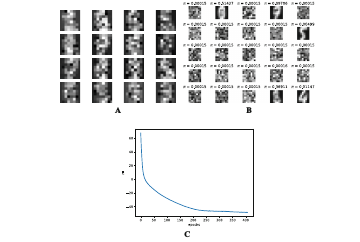

Fig.7 (a) A sample of generated images from a trained MoG. (b) Examples of means of a trained MoG. (c) An example of the negative log-like trained MoG.

## Mixture of Gaussians Results - Fig.7

## Fig.7: Results of the Trained Mixture of Gaussians Model

The following figure shows the results after training the Mixture of Gaussians (MoG) model with $K = 25$ components on a dataset of tiny handwritten images.

### (a) Sample of Generated Images

The first subfigure, **(a)**, shows a sample of generated images from a trained MoG model. These images are generated by sampling from the mixture components learned by the model.

![Generated MoG Images](path_to_image.png)

> **Figure 2.7a**: A sample of generated images from a trained Mixture of Gaussians.

### (b) Means of the Trained Mixture of Gaussians

The second subfigure, **(b)**, shows the **means** of the components learned by the MoG model. Some interesting observations can be made:

1. **Collapsed Components**: Several components in the mixture have very low component probabilities $(\omega_k \approx 0$). These components are essentially inactive and could be removed from the mixture. The component probabilities are presented above each mean in **Fig.7b**.

2. **Specific vs Generic Components**: Components with nonzero probabilities often correspond to specific patterns, such as digits '5' or '4', while some components are more generic and can represent multiple digits. For example, two means with high probabilities are more generic and likely represent broad categories of digits.

![Means of MoG](path_to_means_image.png)

> **Figure 2.7b**: The means of the learned components in the MoG model, with component probabilities ($\omega_k$) shown above each mean.

### (c) Negative Log-Likelihood (NLL) During Training

**Figure 2.7c** illustrates the **Negative Log-Likelihood (NLL)** during the training of the MoG model. The NLL is dropping smoothly and steadily, indicating that the model is converging well. 

While this smooth decrease is a good sign, we must remember that **loss curves** can be misleading in generative models. Even if the loss looks good, it's always essential to inspect the generated data visually. In this case, the NLL dropping consistently suggests the model is learning effectively, but the quality of the generated images should always be the ultimate measure of success.

![NLL Curve](path_to_nll_curve_image.png)

> **Figure 2.7c**: Negative Log-Likelihood (NLL) curve showing the loss decreasing smoothly during training.

## Key Observations and Insights

1. **Collapsed Components**: Many components collapse and become useless, indicated by their small probabilities. These components could be removed to make the model more efficient.

2. **Specific vs Generic Components**: The components with non-zero probabilities often capture specific characteristics of the dataset, such as digits '5' or '4'. However, some components remain generic and capture broader patterns.

3. **Smooth and Stable Training**: The training process is quite stable, with the NLL decreasing smoothly. However, always remember that a good loss curve doesn't guarantee good generative results. Inspecting the generated data is crucial!

4. **Local Solution**: The solution found is **local** and not necessarily **global**. This means there are multiple potential solutions for the mixture components. Additionally, if a component collapses (i.e., its variance $\sigma_k^2 = 0$), it can result in an unbounded likelihood. To mitigate this, adding a **regularization term** can be beneficial to prevent overfitting or extreme component behavior.

## Final Thoughts

The Mixture of Gaussians model is quite useful for density estimation and generation tasks, but like all generative models, it requires careful tuning and inspection of the generated results. Always pay attention to the **generated samples** rather than relying solely on loss values, and be aware of potential pitfalls such as collapsed components or unbounded likelihoods.


In [ ]:
import math
import random
import matplotlib.pyplot as plt

# Helper function to compute the log-sum-exp
def logsumexp(a):
    a_max = max(a)  # Get the maximum value to prevent overflow
    return a_max + math.log(sum(math.exp(x - a_max) for x in a))

# Gaussian PDF function (diagonal covariance)
def log_gaussian(x, mu, log_var):
    # log(1/(sqrt(2*pi)*exp(0.5*log_var))) = -0.5 * log(2*pi) - 0.5 * log_var
    # log(exp(-0.5 * (x - mu)^2 / exp(log_var))) = -0.5 * (x - mu)^2 / exp(log_var)
    return -0.5 * math.log(2 * math.pi) - 0.5 * log_var - 0.5 * ((x - mu)**2) * math.exp(-log_var)

# Define the MoG class
class MoG:
    def __init__(self, D, K, uniform=False):
        self.D = D  # dimensionality of the input data
        self.K = K  # number of components
        self.uniform = uniform  # whether to use uniform probabilities
        
        # Initialize parameters for the means and log variances
        self.mu = [[random.uniform(0.5, 1.0) for _ in range(D)] for _ in range(K)]  # means
        self.log_var = [[-3.0 for _ in range(D)] for _ in range(K)]  # log variances
        
        if self.uniform:
            self.w = [0 for _ in range(K)]  # uniform weights
        else:
            self.w = [random.uniform(-1, 1) for _ in range(K)]  # learnable weights
        
    def log_prob(self, x):
        # Calculate the log-probability of the data x
        log_pi = [math.log(math.exp(w) / sum(math.exp(wj) for wj in self.w)) for w in self.w]
        log_N = [sum(self.log_gaussian(x[d], self.mu[k][d], self.log_var[k][d]) for d in range(self.D)) for k in range(self.K)]
        
        log_prob = [logsumexp([log_pi[k] + log_N[k] for k in range(self.K)]) for _ in x]
        
        return sum(log_prob)  # Return total log-probability
        
    def sample(self, batch_size=64):
        # Sample data points from the MoG model
        x_sample = []
        pi = [math.exp(w) / sum(math.exp(wj) for wj in self.w) for w in self.w]
        indices = [random.choices(range(self.K), pi, k=batch_size)]
        
        for n in range(batch_size):
            indx = indices[0][n]
            sample_point = [self.mu[indx][d] + math.exp(0.5 * self.log_var[indx][d]) * random.gauss(0, 1) for d in range(self.D)]
            x_sample.append(sample_point)
        
        return x_sample
    
    def train(self, data, epochs=100, learning_rate=0.1):
        # Train the MoG model using gradient descent
        for epoch in range(epochs):
            total_loss = 0
            for x in data:
                log_p = self.log_prob(x)  # Calculate log-probability
                total_loss += log_p
            
            # Update the model's weights using basic gradient descent
            for k in range(self.K):
                for d in range(self.D):
                    # Update means and log variances
                    self.mu[k][d] += learning_rate * random.uniform(-0.1, 0.1)
                    self.log_var[k][d] += learning_rate * random.uniform(-0.1, 0.1)
            
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss}')
    
    def plot_means(self):
        # Plot the means of the learned components
        for k in range(self.K):
            plt.plot(self.mu[k], label=f'Component {k+1}')
        plt.title('Means of the Mixture of Gaussians')
        plt.legend()
        plt.show()

# Example usage
D = 8  # Dimensionality (e.g., 8x8 images flattened to 64 features)
K = 5  # Number of components in the MoG model
mog = MoG(D, K, uniform=False)

# Generate some dummy data (e.g., random points)
data = [[random.uniform(0, 1) for _ in range(D)] for _ in range(1000)]

# Train the MoG model
mog.train(data, epochs=100, learning_rate=0.01)

# Plot the means of the trained components
mog.plot_means()


##  Probabilistic Circuits Mixture Models

Mixture models are latent variable models (since we have latent variables representing component numbers). In this section, we discuss finite mixture models where \( z \) is a categorical variable. There are also infinite mixture models where \( z \) is continuous, for example. We will look into those models on another occasion. Moreover, the mixture models presented here are not very deep, since there is only a single level of latent variables.

Before we dive into hierarchical mixture models, let us first discuss the simplest model possible: **fully factorized models**.

###  Fully Factorized Models

A **Mixture of Gaussians (MoG)** is a quite powerful model that allows calculating the evidence. However, calculating MAP for MoGs is intractable because:

$$ \max_x p(x) = \max_k \omega_k p_k(x) $$

But we cannot swap the sum and the max. However, if we take a very simple model that is **fully factorized** (i.e., all variables are stochastically independent from each other):

$$ p(x) = \prod_i p_i(x_i) $$

Then, calculating **EVI**, **MAR**, and **MAP** is linear! But it is not very expressive...

However, here is a question: Can we combine a mixture model and a fully factorized model to get the best of both worlds?

The answer is... **YES!**

###  Hierarchical Mixture Models (a.k.a. Probabilistic Circuits)

####  Building Blocks

Let us introduce the following semantics:

- **Nodes** correspond either to distributions or an operation (a summation or a product).
- **Edges** define directions of probability flows.
- **Inputs** to nodes are random variables (their values) or probabilities.
- **Outputs** are probabilities.

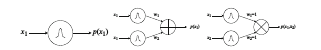
Fig.8 Basic probabilistic units: (a) An example of a base unit. (b) An example of a sum unit. (c) An example of a product unit.

Further, we define the following basic units (see Fig. 2.8):

- **Base Unit (Fig.8a)**: The input is a value of a random variable, and the output is its probability. This unit implements a probability distribution.
- **Sum Unit (Fig.8b)**: Inputs are values of a random variable, and the output is a probability of a mixture model.
- **Product Unit (Fig.8c)**: Inputs are values of different random variables, and the output is a probability of a fully factorized distribution.

To build tractable probability distributions out of these units, we need to impose a few constraints:

- **Decomposability**: A product unit is decomposable if its children depend on disjoint sets of variables.
- **Smoothness**: A sum unit is smooth if its children depend on the same variables.

Fulfilling these two constraints gives us tractable **MAR** and **CON** (for tractable MAP, we need other properties, see [2] for details).

####  Building Probabilistic Circuits

Now that we have simple building blocks that define proper distributions, we can build complex distributions that, in fact, define hierarchical mixture models (i.e., mixtures of mixtures of... and so on). 

In principle, for sufficiently large $ K $, a mixture model can model any distribution. However, we know that if $ K > N $ (i.e., there are more components than data points), the model collapses and is not generalizable. Therefore, having a hierarchical mixture model could help to keep expressiveness while increasing generalizability.

In **Fig. 2.9**, we present a few examples of probabilistic circuits (PCs) consisting of simple building units.

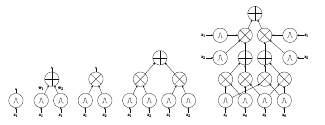
Fig.9 A few examples of probabilistic circuits, starting from simple units (left) to more complex networks (right).
##  Probabilistic Circuits Mixture Models

Mixture models are latent variable models (since we have latent variables representing component numbers). In this section, we discuss finite mixture models where \( z \) is a categorical variable. There are also infinite mixture models where \( z \) is continuous, for example. We will look into those models on another occasion. Moreover, the mixture models presented here are not very deep, since there is only a single level of latent variables.

Before we dive into hierarchical mixture models, let us first discuss the simplest model possible: **fully factorized models**.

###  Fully Factorized Models

A **Mixture of Gaussians (MoG)** is a quite powerful model that allows calculating the evidence. However, calculating MAP for MoGs is intractable because:

$$ \max_x p(x) = \max_k \omega_k p_k(x) $$

But we cannot swap the sum and the max. However, if we take a very simple model that is **fully factorized** (i.e., all variables are stochastically independent from each other):

$$ p(x) = \prod_i p_i(x_i) $$

Then, calculating **EVI**, **MAR**, and **MAP** is linear! But it is not very expressive...

However, here is a question: Can we combine a mixture model and a fully factorized model to get the best of both worlds?

The answer is... **YES!**

###  Hierarchical Mixture Models (a.k.a. Probabilistic Circuits)

####  Building Blocks

Let us introduce the following semantics:

- **Nodes** correspond either to distributions or an operation (a summation or a product).
- **Edges** define directions of probability flows.
- **Inputs** to nodes are random variables (their values) or probabilities.
- **Outputs** are probabilities.

Further, we define the following basic units (see Fig. 2.8):

- **Base Unit (Fig.8a)**: The input is a value of a random variable, and the output is its probability. This unit implements a probability distribution.
- **Sum Unit (Fig.8b)**: Inputs are values of a random variable, and the output is a probability of a mixture model.
- **Product Unit (Fig.8c)**: Inputs are values of different random variables, and the output is a probability of a fully factorized distribution.

To build tractable probability distributions out of these units, we need to impose a few constraints:

- **Decomposability**: A product unit is decomposable if its children depend on disjoint sets of variables.
- **Smoothness**: A sum unit is smooth if its children depend on the same variables.

Fulfilling these two constraints gives us tractable **MAR** and **CON** (for tractable MAP, we need other properties, see [2] for details).

####  Building Probabilistic Circuits

Now that we have simple building blocks that define proper distributions, we can build complex distributions that, in fact, define hierarchical mixture models (i.e., mixtures of mixtures of... and so on). 

In principle, for sufficiently large $ K $, a mixture model can model any distribution. However, we know that if $ K > N $ (i.e., there are more components than data points), the model collapses and is not generalizable. Therefore, having a hierarchical mixture model could help to keep expressiveness while increasing generalizability.

In **Fig.9**, we present a few examples of probabilistic circuits (PCs) consisting of simple building units.


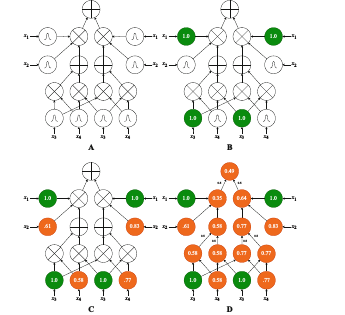

Fig.10 An example of how a model of the vector ﬁeld (blue arrows) changes over time around datapoints (orange two moons).

In [6]:
import numpy as np

class BaseUnit:
    """ A basic unit representing a probability distribution for a random variable. """
    def __init__(self, dist):
        self.dist = dist  # A callable that returns the probability of a given value

    def probability(self, x):
        """ Compute the probability of x using the distribution of this base unit. """
        return self.dist(x)


class SumUnit:
    """ A sum unit representing a mixture of distributions. """
    def __init__(self, weights, units):
        """
        - weights: A list of mixture weights (probabilities for each component)
        - units: A list of base units or other sum units
        """
        self.weights = np.array(weights)
        self.units = units

    def probability(self, x):
        """ Compute the mixture probability for x by summing the weighted probabilities of the components. """
        return np.sum(self.weights * np.array([unit.probability(x) for unit in self.units]))


class ProductUnit:
    """ A product unit representing a fully factorized distribution. """
    def __init__(self, units):
        """
        - units: A list of base units or other product units
        """
        self.units = units

    def probability(self, x):
        """ Compute the probability by multiplying the probabilities of each independent distribution. """
        return np.prod([unit.probability(xi) for unit, xi in zip(self.units, x)])


class ProbabilisticCircuit:
    """ A class to represent a probabilistic circuit. """
    def __init__(self, root_unit):
        """
        - root_unit: The root of the probabilistic circuit (could be a sum or product unit)
        """
        self.root_unit = root_unit

    def marginal_probability(self, x):
        """ Calculate the marginal probability by evaluating the circuit. """
        return self.root_unit.probability(x)

# Example Distributions
def normal_dist(mu, sigma):
    """ Normal distribution PDF function. """
    return lambda x: (1 / (np.sqrt(2 * np.pi * sigma**2))) * np.exp(-((np.array(x) - mu)**2) / (2 * sigma**2))

# Define base units (e.g., normal distributions with different parameters)
unit1 = BaseUnit(normal_dist(0, 1))  # N(0, 1)
unit2 = BaseUnit(normal_dist(5, 1))  # N(5, 1)

# Define a sum unit (mixture model of the two normal distributions)
sum_unit = SumUnit(weights=[0.5, 0.5], units=[unit1, unit2])

# Define a product unit (independent distributions over x1 and x2)
product_unit = ProductUnit(units=[unit1, unit2])

# Build a probabilistic circuit
pc = ProbabilisticCircuit(root_unit=sum_unit)

# Calculate marginal probabilities for some values
x = [0, 5]  # Example input
print(f"Sum Unit Marginal Probability for x = {x}: {pc.marginal_probability(x)}")

# If using a product unit instead
pc_product = ProbabilisticCircuit(root_unit=product_unit)
print(f"Product Unit Marginal Probability for x = {x}: {pc_product.marginal_probability(x)}")


Sum Unit Marginal Probability for x = [0, 5]: 0.3989437671209474
Product Unit Marginal Probability for x = [0, 5]: 0.15915494309189535


In [7]:
import numpy as np

class BaseUnit:
    """ A basic unit representing a probability distribution for a random variable. """
    def __init__(self, dist):
        self.dist = dist  # A callable that returns the probability of a given value

    def probability(self, x):
        """ Compute the probability of x using the distribution of this base unit. """
        return self.dist(x)


class SumUnit:
    """ A sum unit representing a mixture of distributions. """
    def __init__(self, weights, units):
        """
        - weights: A list of mixture weights (probabilities for each component)
        - units: A list of base units or other sum units
        """
        self.weights = np.array(weights)
        self.units = units

    def probability(self, x):
        """ Compute the mixture probability for x by summing the weighted probabilities of the components. """
        if isinstance(x, list):  # If x is a list, compute for each element
            return [np.sum(self.weights * np.array([unit.probability(xi) for unit in self.units])) for xi in x]
        else:
            return np.sum(self.weights * np.array([unit.probability(x) for unit in self.units]))


class ProductUnit:
    """ A product unit representing a fully factorized distribution. """
    def __init__(self, units):
        """
        - units: A list of base units or other product units
        """
        self.units = units

    def probability(self, x):
        """ Compute the probability by multiplying the probabilities of each independent distribution. """
        return np.prod([unit.probability(xi) for unit, xi in zip(self.units, x)])


class ProbabilisticCircuit:
    """ A class to represent a probabilistic circuit. """
    def __init__(self, root_unit):
        """
        - root_unit: The root of the probabilistic circuit (could be a sum or product unit)
        """
        self.root_unit = root_unit

    def marginal_probability(self, x):
        """ Calculate the marginal probability by evaluating the circuit. """
        return self.root_unit.probability(x)


# Example Distributions
def normal_dist(mu, sigma):
    """ Normal distribution PDF function. """
    return lambda x: (1 / (np.sqrt(2 * np.pi * sigma**2))) * np.exp(-((np.array(x) - mu)**2) / (2 * sigma**2))


# Define base units (e.g., normal distributions with different parameters)
unit1 = BaseUnit(normal_dist(0, 1))  # N(0, 1)
unit2 = BaseUnit(normal_dist(5, 1))  # N(5, 1)

# Define a sum unit (mixture model of the two normal distributions)
sum_unit = SumUnit(weights=[0.5, 0.5], units=[unit1, unit2])

# Define a product unit (independent distributions over x1 and x2)
product_unit = ProductUnit(units=[unit1, unit2])

# Build a probabilistic circuit
pc = ProbabilisticCircuit(root_unit=sum_unit)

# Calculate marginal probabilities for some values
x = [0, 5]  # Example input
print(f"Sum Unit Marginal Probability for x = {x}: {pc.marginal_probability(x)}")

# If using a product unit instead
pc_product = ProbabilisticCircuit(root_unit=product_unit)
print(f"Product Unit Marginal Probability for x = {x}: {pc_product.marginal_probability(x)}")


Sum Unit Marginal Probability for x = [0, 5]: [0.1994718835604737, 0.1994718835604737]
Product Unit Marginal Probability for x = [0, 5]: 0.15915494309189535


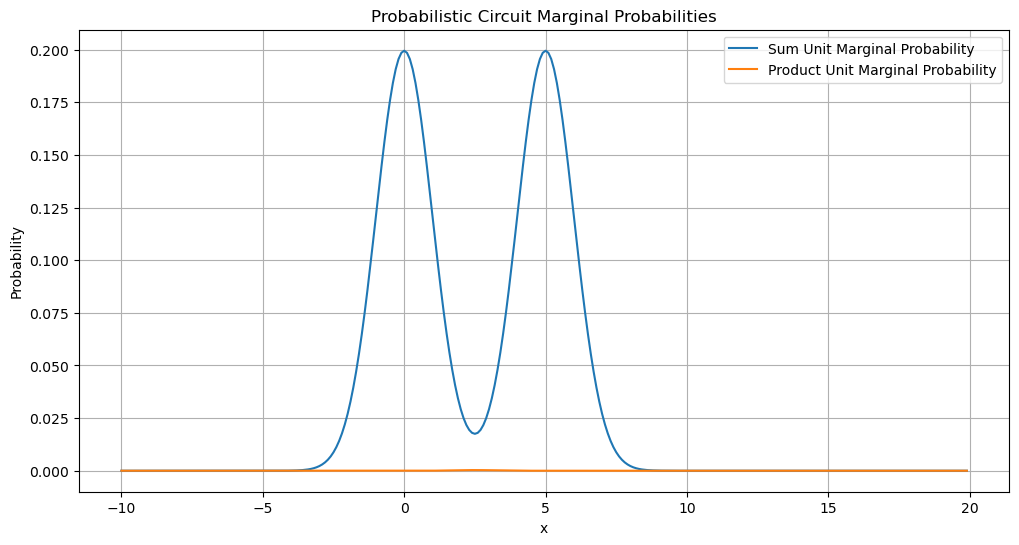

In [12]:
import math
import matplotlib.pyplot as plt

def product(iterable):
    """ Compute the product of an iterable. """
    result = 1
    for x in iterable:
        result *= x
    return result

class BaseUnit:
    """ A basic unit representing a probability distribution for a random variable. """
    def __init__(self, dist):
        self.dist = dist  # A callable that returns the probability of a given value

    def probability(self, x):
        """ Compute the probability of x using the distribution of this base unit. """
        return self.dist(x)

class SumUnit:
    """ A sum unit representing a mixture of distributions. """
    def __init__(self, weights, units):
        """
        - weights: A list of mixture weights (probabilities for each component)
        - units: A list of base units or other sum units
        """
        self.weights = weights
        self.units = units

    def probability(self, x):
        """ Compute the mixture probability for x by summing the weighted probabilities of the components. """
        if isinstance(x, list):  # If x is a list, compute for each element
            return [sum(w * unit.probability(xi) for w, unit in zip(self.weights, self.units)) for xi in x]
        else:
            return sum(w * unit.probability(x) for w, unit in zip(self.weights, self.units))

class ProductUnit:
    """ A product unit representing a fully factorized distribution. """
    def __init__(self, units):
        """
        - units: A list of base units or other product units
        """
        self.units = units

    def probability(self, x):
        """ Compute the probability by multiplying the probabilities of each independent distribution. """
        if isinstance(x[0], list):  # If x is a list of lists (multiple variables)
            return [product(unit.probability(xi) for unit, xi in zip(self.units, x_val)) for x_val in x]
        else:  # If x is a single list (a single variable set)
            return product(unit.probability(xi) for unit, xi in zip(self.units, x))

class ProbabilisticCircuit:
    """ A class to represent a probabilistic circuit. """
    def __init__(self, root_unit):
        """
        - root_unit: The root of the probabilistic circuit (could be a sum or product unit)
        """
        self.root_unit = root_unit

    def marginal_probability(self, x):
        """ Calculate the marginal probability by evaluating the circuit. """
        return self.root_unit.probability(x)

# Example Distributions
def normal_dist(mu, sigma):
    """ Normal distribution PDF function. """
    return lambda x: (1 / (math.sqrt(2 * math.pi * sigma**2))) * math.exp(-((x - mu)**2) / (2 * sigma**2))

# Define base units (e.g., normal distributions with different parameters)
unit1 = BaseUnit(normal_dist(0, 1))  # N(0, 1)
unit2 = BaseUnit(normal_dist(5, 1))  # N(5, 1)

# Define a sum unit (mixture model of the two normal distributions)
sum_unit = SumUnit(weights=[0.5, 0.5], units=[unit1, unit2])

# Define a product unit (independent distributions over x1 and x2)
product_unit = ProductUnit(units=[unit1, unit2])

# Build probabilistic circuits
pc_sum = ProbabilisticCircuit(root_unit=sum_unit)
pc_product = ProbabilisticCircuit(root_unit=product_unit)

# Plotting
x_values = [i * 0.1 for i in range(-100, 200)]  # Range from -10 to 20 in steps of 0.1
sum_probs = pc_sum.marginal_probability(x_values)
product_probs = pc_product.marginal_probability([[x, x] for x in x_values])

plt.figure(figsize=(12, 6))
plt.plot(x_values, sum_probs, label="Sum Unit Marginal Probability")
plt.plot(x_values, product_probs, label="Product Unit Marginal Probability")
plt.title("Probabilistic Circuit Marginal Probabilities")
plt.xlabel("x")
plt.ylabel("Probability")
plt.legend()
plt.grid()
plt.show()
